```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - PM2.5 - Autoregression (AR)

## Contents

- [Autoregression (AR) modelling](#base)
- Hourly forecast
    - [Load hourly data](#data_h)
    - [Diagnostics](#diag_h)
    - [Modelling](#model_h)
- Daily forecast
    - [Load daily data](#data_d)
    - [Diagnostics](#diag_d)
    - [Modelling](#model_d)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../src')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd 
import numpy as np

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
from model import (
    get_pm25_data_for_modelling,
    get_best_arima_params_for_time_series,
    get_df_for_lags_columns
)

from measure import (
    get_model_power,
    get_rmse
)

from plot import (
    #plot_train_test_predicted,
    plot_observed_vs_predicted,
    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot,
    plot_observed_vs_predicted_with_error
)

from stats import (
    adfuller_test
)

[autoreload of plot failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../src/plot/__init__.py", line 3, in <module>
    from .ts_plots import (
ImportError: cannot import

ImportError: cannot import name 'plot_observed_vs_predicted_with_error' from 'plot' (../src/plot/__init__.py)

---
<a id='base'></a>

## Autoregression (AR) modelling

Autoregression modeling is a modeling technique used for time series data that assumes linear continuation of the series so that previous values in the time series can be used to predict futures values. 

Autoregression technique is similar to linear regression where, you’re taking all of the previous data points to build a model to predict a future data point using a simple linear model. With the autoregression model, your’e using previous data points and using them to predict future data point(s) but with multiple lag variables.

---
<a id='data_h'></a>

## Load hourly data

In [7]:
##### ZMIENIC 'd' na 'h'
dfh = get_pm25_data_for_modelling('ts', 'd')
dfh.head()

common.py | 42 | get_pm25_data_for_modelling | 07-Jun-20 19:56:04 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 07-Jun-20 19:56:04 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [8]:
model_name = 'AR'

In [9]:
df = dfh.copy()

In [10]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [11]:
# Define first past/future cutoff point in time offset (1 year of data)
#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Set datetime format for index
#dt_format = "%Y-%m-%d %H:%M:%S" # for hourly data
dt_format = "%Y-%m-%d" # for daily data

# Set proper frequency for modelling
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#df.index = pd.DatetimeIndex(df.index).to_period('H') # for hourly data
#df.index = pd.DatetimeIndex(df.index).to_period('D') # for daily data

In [12]:
# Create train / test datasets
X = df.dropna()
df_train = X[1:len(X)-cut_off_offset]
df_test = X[len(X)-cut_off_offset:]

In [13]:
df_train.shape

(3653, 1)

In [14]:
df_test.shape

(365, 1)

In [15]:
# Train the model
model = AR(df_train)
model_fitted = model.fit()

In the above, we are simply creating a testing and training dataset and then creating and fitting our AR() model. The AR() function tries to estimate the number of lags for the prediction. Once you’ve fit the model, you can look at the chosen lag and parameters of the model using some simple print statements.

In [16]:
model_fitted

In [17]:
print(f'The lag value chose is: {model_fitted.k_ar}')

The lag value chose is: 30


In [18]:
print(f'The coefficients of the model are:\n {model_fitted.params}')

The coefficients of the model are:
 const       3.254686
L1.pm25     0.702070
L2.pm25    -0.144036
L3.pm25     0.078781
L4.pm25    -0.012828
L5.pm25     0.002850
L6.pm25     0.018810
L7.pm25     0.026406
L8.pm25     0.040924
L9.pm25     0.008997
L10.pm25   -0.038482
L11.pm25    0.040293
L12.pm25    0.076362
L13.pm25   -0.011441
L14.pm25    0.049392
L15.pm25   -0.055448
L16.pm25    0.066617
L17.pm25   -0.002334
L18.pm25   -0.003607
L19.pm25    0.056132
L20.pm25   -0.013051
L21.pm25    0.066457
L22.pm25   -0.004800
L23.pm25    0.003229
L24.pm25   -0.039893
L25.pm25    0.012186
L26.pm25    0.016868
L27.pm25   -0.036194
L28.pm25    0.018096
L29.pm25   -0.022881
L30.pm25    0.014114
dtype: float64


In [19]:
# Prepare history data frame with lagged columns

In [100]:
# Out of sample prediction

def predict_ar(X: list, coef: list) -> float:
    yhat = 0.0
    #print(f'coef -> {coef}')
    #print(f'X -> {X}')
    for i in range(1, len(coef)):
        # X values must be applied backwards as we travel back in the past
        yhat += coef[i] * X[-i]
        #print(coef[i], X[i], yhat)
    return yhat + coef[0]

from sklearn.metrics import mean_squared_error
def calculate_rmse_for_row(row):
    #return get_rmse(observed=row['observed'], predicted=row['predicted'])
    #return round(mean_squared_error(row['observed'], row['predicted']), 4)
    pass


# ZMien nazwe na walk forward model validation method
def predict_out_of_sample_ar2(data: pd.DataFrame, col_name: str, model_params: list, cut_off_offset:int = 365, n_pred_points: int = 1, n_folds: int = -1):
    
    # it takes entire dataset and splits it to train/test according to train_test_split_position using cut_off_offset
    train_test_split_position = int(len(data)-cut_off_offset)    
    max_n_folds = len(data) - train_test_split_position
    
    if n_folds < 1:
        last_n_folds_pos = len(data)
    else:
        if n_folds > max_n_folds:
            last_n_folds_pos = max_n_folds
        else:
            last_n_folds_pos = train_test_split_position + n_folds
    
    #print(range(train_test_split_position, n_folds))
    
    # A list of data frames with results from each fold n_pred_points predictions
    fold_results = []
    
    # Do this for each data point in the test part
    for i in range(train_test_split_position, last_n_folds_pos):
        
        # For each fold
        history = data[0:i].copy()
        future = data[i:i+n_pred_points].copy()
        
        #print(f'history.shape {history.shape}')
        #print(f'future.shape {future.shape}')
        #print(history.head(1))
        #print(future.head(10))
        
        predicted = []
        
        # Forecast values for n_pred_points
        for j in range(len(future)):
            
            #print(history.tail(5))
            
            # Get prediction for t+1 lag
            yhat = predict_ar(history[col_name].tail(len(model_params)+1).tolist(), model_params)
            #print(list(reversed(history[col_name].tail().tolist())))
            
            #history[col_name].tail(len(model_params)).tolist()

            # Add it as a predicted value
            predicted.append(yhat)
            #print(predicted)

            # Create a new row with the next data point index from df_test
            # Extend history with the last predicted value
            history = history.append(future[j:j+1])
            
            # Replace observed value with predicted value
            history.loc[future[j:j+1].index] = [yhat]
            
        # Summarize results for the fold
        # Each row represents next predicted lag
        df_fold_observed = future[col_name].copy() # observed
        df_fold_predicted = history[-n_pred_points:].copy() # predicted
        df_fold_results = pd.concat([df_fold_observed, df_fold_predicted], axis=1)
        df_fold_results.columns = ['observed', 'predicted']
        
        df_fold_results['error'] = np.abs(df_fold_results['observed'] - df_fold_results['predicted']) # error
        df_fold_results['abs_error'] = np.abs(df_fold_results['observed'] - df_fold_results['predicted']) # absolute error
        
        fold_results.append(df_fold_results)
        #print(df_fold_results)
    
    return fold_results

In [101]:
#fold_results = predict_out_of_sample_ar2(model_params=[3.254686, 0.702070, -0.144036], data=df, col_name='pm25', n_pred_points=5)
#fold_results = predict_out_of_sample_ar2(model_params=model_fitted.params, data=df, col_name='pm25', n_pred_points=1)
#df_compared.head()

#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

fold_results = predict_out_of_sample_ar2(data=df, 
                                         col_name='pm25', 
                                         model_params=[3.254686, 0.702070, -0.144036], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=1)

In [102]:
len(fold_results)

1

In [103]:
fold_results[0]

,observed,predicted,error,abs_error
Datetime,,,,
2018-01-02,67.991848,38.338665,29.653182,29.653182
2018-01-03,16.026950,22.536039,6.509089,6.509089
2018-01-04,14.590020,13.554415,1.035605,1.035605
2018-01-05,22.094854,9.524833,12.570021,12.570021
2018-01-06,62.504217,7.989462,54.514755,54.514755
2018-01-07,43.929804,7.491929,36.437876,36.437876
2018-01-08,22.088192,7.363774,14.724417,14.724417


In [99]:
# One point forecast - part 1

dac trenowanie modelu i przyfotowanie danych

SyntaxError: invalid syntax (<ipython-input-99-135e2caa04ac>, line 3)

In [39]:
type(model_fitted.params)

pandas.core.series.Series

In [104]:
# One point forecast - part 2

#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

fold_results = predict_out_of_sample_ar2(data=df, 
                                         col_name='pm25', 
                                         model_params=model_fitted.params[:], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=-1)


print(len(fold_results))
print(fold_results[0])

365
             observed  predicted      error  abs_error
Datetime                                              
2018-01-02  67.991848  49.379772  18.612076  18.612076
2018-01-03  16.026950  46.310684  30.283734  30.283734
2018-01-04  14.590020  42.722729  28.132708  28.132708
2018-01-05  22.094854  36.818753  14.723899  14.723899
2018-01-06  62.504217  39.552410  22.951806  22.951806
2018-01-07  43.929804  44.885109   0.955304   0.955304
2018-01-08  22.088192  47.602331  25.514139  25.514139


In [105]:
fold_results[0][:1]

,observed,predicted,error,abs_error
Datetime,,,,
2018-01-02,67.991848,49.379772,18.612076,18.612076


In [130]:
# One point forecast - part 3

show_n_points_of_foreacst = 3

start_index = show_n_points_of_foreacst - 1
end_index = show_n_points_of_foreacst

observed = pd.Series()
predicted = pd.Series()
for fold in fold_results:
    # Take first row (1 step prediction)
    observed = observed.append(fold[start_index:end_index]['observed'])
    predicted = predicted.append(fold[start_index:end_index]['predicted'])
#print(observed.shape)
#observed.head()

In [ ]:
plot_observed_vs_predicted_wi(observed=observed, 
                           predicted=predicted, 
                           num_points=cut_off_offset*20, 
                           title=model_name,
                           label_observed='PM2.5 observed', 
                           label_predicted='PM2.5 predicted', 
                           save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')

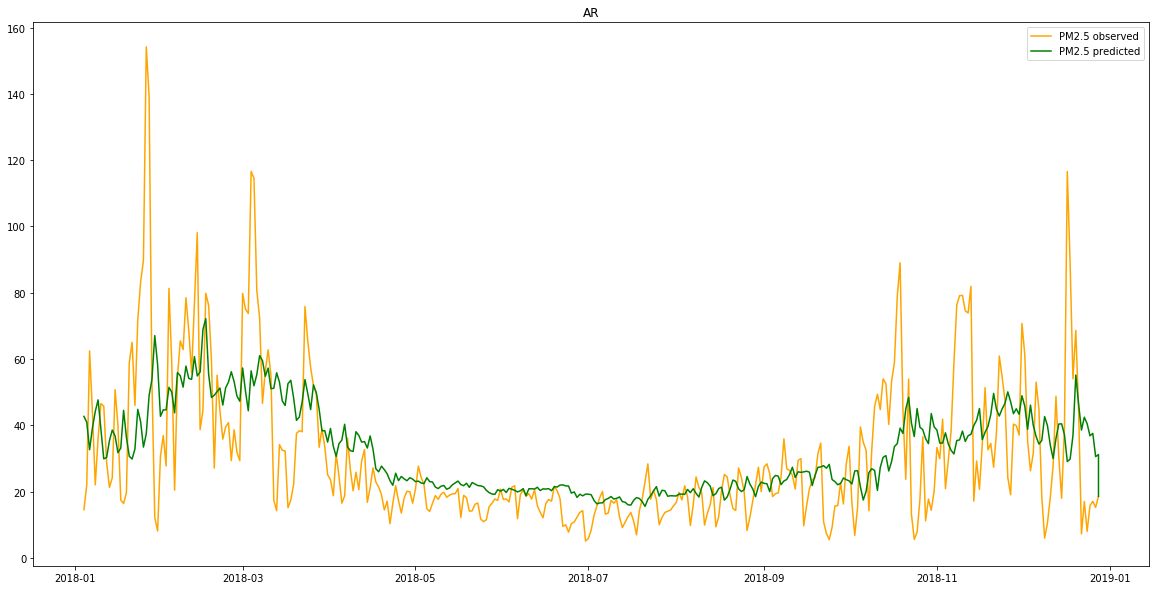

In [131]:
# This plot does show combined x-days forecast for specified data points for model quality comparison.

plot_observed_vs_predicted(observed=observed, 
                           predicted=predicted, 
                           num_points=cut_off_offset*20, 
                           title=model_name,
                           label_observed='PM2.5 observed', 
                           label_predicted='PM2.5 predicted', 
                           save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')

In [ ]:
df_test.index[len(df_test)-1].strftime(dt_format)

In [ ]:
def perform_walk_forward_validation(data: pd.DataFrame, 
                                    model_fit,
                                    model_predict,
                                    train_test_split_position: int, 
                                    n_folds: int, 
                                    n_pred_points: int, 
                                    dt_format: str,
                                   s_name: str) -> pd.Series:
    tsfolds_rmse = pd.Series()

    for i in range(train_test_split_position, n_folds):

        # For each fold
        train = data[0:i].copy()
        validation = data[i:i+n_pred_points].copy()

        # Fit the model: Take an average of train
        model_fitted = model_fit(data=train)

        # Predict for all values in validation
        predicted = validation.copy()
        
        #print(len(train))
        #print(len(validation))
        #print(len(predicted))
        #print(model_fitted.values[0])
        
        predicted['pred'] = model_predict(model_fitted, predicted)

        rmse = get_rmse(observed=validation[s_name], predicted=predicted['pred'])
        tsfolds_rmse.set_value(label=df.iloc[0:].index[i].strftime(dt_format), value=rmse)
        
    # Convert to data frame and datetime index
    tsfolds_rmse = tsfolds_rmse.to_frame(name=s_name)
    tsfolds_rmse.index = pd.to_datetime(tsfolds_rmse.index)
        
    return tsfolds_rmse

In [ ]:
from datetime import datetime

In [ ]:
# make in sample predictions 
#predictions = model_fitted.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1, dynamic=False)
predictions = model_fitted.predict(start=datetime(2017, 1, 1), end=datetime(2019, 1, 1), dynamic=False)

In [ ]:
predictions.shape

In [ ]:
plot_observed_vs_predicted(observed=df_train, 
                           predicted=predictions, 
                           num_points=cut_off_offset*2, 
                           title=model_name,
                           label_observed='PM2.5 observed', 
                           label_predicted='PM2.5 predicted', 
                           save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')

In [ ]:
predictions

In [ ]:
https://machinelearningmastery.com/make-manual-predictions-arima-models-python/

In [ ]:
# Make out of sample predictions (on a test set)



In [ ]:
get_df_for_lags_columns(data=df, col_name='pm25', n_lags=10, remove_nans=True).head(10+1)

In [ ]:
model = ARIMA(df_train, order=(1,0,0))
model_fit = model.fit()
ar_coef = model_fit.arparams
predict(ar_coef, df_test)

In [ ]:
#history = [x for x in df_train]
#print(history)
predictions = []

for t in range(len(df_test)):
    model = ARIMA(df_train, order=(1,0,0))
    model_fit = model.fit()
    ar_coef = model_fit.arparams
    
    yhat = predict(ar_coef, history)
    predictions.append(yhat)
    obs = df_test[t]
    history.append(obs)
    print('>predicted=%.3f, expected=%.3f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
model.params

In [ ]:
series = df_train['pm25']
test_series = df_test['pm25']

print(series)

model_fitted = ARIMA(series, order).fit()
print(model_fitted.params)

test_model = ARIMA(test_series, order).fit()
test_model.predict()#, start=0, end=len(test_series)-1)

In [ ]:
#%%time
# Make out of sample predictions (on a test set)
#p = model_fitted.k_ar
#p = 3
order = (3, 0, 0)
train_model = ARIMA(df_train, order=order).fit()
test_model = ARIMA(df_test, order=order).fit()
#predictions = 
test_model.predict(test_model.params)

In [ ]:
df_test['pm25'].head()

In [ ]:
predictions.head()

In [ ]:
(df_test.shape, predictions.shape)

In [ ]:
plot_observed_vs_predicted(observed=df_test, 
                           predicted=predictions, 
                           num_points=cut_off_offset, 
                           title=model_name,
                           label_observed='PM2.5 observed', 
                           label_predicted='PM2.5 predicted', 
                           save_path='images/pm25_obs_vs_pred_365_h_ref_simple_average.png')

---
<a id='diag_h'></a>

## Diagnostics

In [ ]:
# Plot the time series against its lag1
plt.figure(figsize=(10, 10))
lag_plot(df)
plt.show();

In [ ]:
# Calculate autocorrelation coefficient
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
df1.head()

In [ ]:
df1.corr(method='pearson')

In [ ]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(20, 10))
autocorrelation_plot(df)
plt.show();

In [ ]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=90000)
plt.show();

In [ ]:
# Plot the AutoCorrelation Function, using candle sticks
fig, (ax) = plt.subplots(1, 1, figsize=(20, 10))
plot_acf(df, ax=ax, lags=100)
plt.show();

In [ ]:
adfuller_test(df)

What we can see here is yearly and daily cycles and the most influencing (autocorrelated) hourly lags being closer to the observation point at lag 0. For statistical times eries modelling, we must decompose our

---
<a id='model_h'></a>

## Modelling

In statistical time series models, fitting the model means estimating its paraneters. In case of AR model, the only parameter to estimate is number of autocorrelated lags

In [ ]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=0) # AR model

In [ ]:
best_results

In [ ]:
SARIMAX(5, 0, 0) - AIC:687066.8937108214
Best model is ARIMA(5, 0, 0) with AIC of 687066.8937108214
CPU times: user 20.8 s, sys: 2.4 s, total: 23.2 s
Wall time: 8.14 s

In [ ]:
# Estimating model

# Fit an AR(5) model
model = ARMA(df, order=(5,0))
result = model.fit()  # use fit() to estimate model

# Estimated parameters
print(result.summary())

# True parameters
print(f'True parameters:\n{result.params}')

**Estimated parameters are close to true parameters. All AR coefficients are statistically significant.**

In [ ]:
df.tail(24)

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.predict.html#statsmodels.tsa.arima_model.ARMAResults.predict
# dynamic = use in-sample predictions
pred = result.predict(start='2018-12-31 01:00:00', end='2019-01-01 00:00:00', dynamic=False)
pred

In [ ]:
# Forecasting (in sample)
# Start the forecast 24 data points before the end of the point series

result.plot_predict(start='2018-12-31 01:00:00', end='2019-01-01 00:00:00', dynamic=False)
plt.show();

In [ ]:
# Forecasting (out of sample)
forecast = result.forecast(24)
plt.plot(forecast[0])
#plt.ylim(0, 40)
plt.show();

In [ ]:
observed = df.iloc[-24:, 0]
predicted = pred

plot_observed_vs_predicted(observed=observed, 
                           predicted=predicted, 
                           num_points=125,
                           title="AR Forecast",
                           label_observed='Observations', 
                           label_predicted='Predictions')

In [ ]:
plot_observations_to_predictions_relationship(observed=observed, 
                                         predicted=predicted, 
                                         title="AR(5)",
                                         label_observed='Observations',
                                         label_predicted='Predictions')

In [ ]:
rmse, r = get_model_power(df.iloc[-24:, 0], pred)
print(f'Naive forecast RMSE: {rmse:.4f}')
print(f'Naive forecast correlation coefficient of the observed-to-predicted values percent change: {r:.4f}')

---
<a id='data_d'></a>

## Load daily data

In [ ]:
data_file = data_path + 'dfpm25_2008-2018_daily.hdf'

df = pd.read_hdf(path_or_buf=data_file, key="df")
print(f'Dataframe size: {df.shape}')
df.head()

---
<a id='diag_d'></a>

## Diagnostics

In [ ]:
# Plot the time series against its lag
lag_plot(df)
plt.show();

In [ ]:
# Calculate autocorrelation coefficient
#values = pd.DataFrame(vacation.values)
df1 = pd.concat([df, df.shift(1)], axis=1)
df1.columns = ['t', 't-1']
#df1.head()
df1.corr(method='pearson')

In [ ]:
# Plot the autocorrelation plot of the dataset
plt.figure(figsize=(10, 6))
autocorrelation_plot(df)
plt.show();

In [ ]:
# Plot the AutoCorrelation Function, using candle sticks
plt.figure(figsize=(12, 6))
fig, (ax) = plt.subplots(1, 1, figsize=(20, 8))
plot_acf(df, ax=ax, lags=200)
plt.show();

---
<a id='model_d'></a>

## Modelling

In [ ]:
%%time
# Find best parameters (grid-search)
best_results = get_best_arima_params_for_time_series(data=df, 
                                                     seasonal=False, 
                                                     max_param_range_p=5, 
                                                     max_param_range_d=0, 
                                                     max_param_range_q=0) # AR model

In [ ]:
best_results

In [ ]:
# Estimating model

# Fit an AR(5) model
model = ARMA(df, order=(5,0))
result = model.fit()  # use fit() to estimate model

# Estimated parameters
print(result.summary())

# True parameters
print(f'True parameters:{result.params}')

**Estimated parameters are close to true parameters. All AR coefficients but L4 are statistically significant.**

In [ ]:
df.tail(7)

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.predict.html#statsmodels.tsa.arima_model.ARMAResults.predict
# dynamic = use in-sample predictions
pred = result.predict(start='2018-12-26', end='2019-01-01', dynamic=False)
pred

In [ ]:
# Forecasting (in-sample)
# Start the forecast 7 data points before the end of the point series

result.plot_predict(start='2018-12-26', end='2019-01-08', dynamic=False)
plt.show();

In [ ]:
# Forecasting (out of sample)
forecast = result.forecast(7)
plt.plot(forecast[0])
#plt.ylim(0, 40)
plt.show();

In [ ]:
observed = df.iloc[-7:, 0]
predicted = pred

plot_observed_vs_predicted(observed=observed, 
                           predicted=predicted, 
                           num_points=125,
                           title="AR Forecast",
                           label_observed='Observations', 
                           label_predicted='Predictions')

In [ ]:
plot_observations_to_predictions_relationship(observed=observed, 
                                         predicted=predicted, 
                                         title="AR(5)",
                                         label_observed='Observations',
                                         label_predicted='Predictions')

In [ ]:
rmse, r = get_model_power(df.iloc[-7:, 0], pred)
print(f'Naive forecast RMSE: {rmse:.4f}')
print(f'Naive forecast correlation coefficient of the observed-to-predicted values percent change: {r:.4f}')